In [55]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import librosa
import numpy as np
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
import joblib

# Noise Features

In [56]:
dae_f = load_model('data/noise_on_features/processed_data/autoencoder_model_features.keras')

In [57]:
dae_f.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 148, 109, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 109, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 55, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 55, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 28, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 66304)             0     

## Load a test audio file

In [58]:
file_path = "/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/test/667626_18933d713e_2.wav"
y_features, sr = librosa.load(file_path)

In [59]:
sr, y_features[0].shape

(22050, ())

In [60]:
ipd.Audio(y_features, rate=sr)

## Preprocess the audio file

#### Add noise

In [61]:
def add_noise(feature, mean=0, std=0.05):
    noise = np.random.normal(mean, std, feature.shape)
    return feature + noise

In [62]:
y_features_noisy = add_noise(y_features)
ipd.Audio(y_features_noisy, rate=sr)

#### Extract mfcc and melspectrogram

In [63]:
sr=22050 
n_fft=2048
hop_length=512
n_mels=128
n_mfcc=20
fixed_length=55296
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/weights/scaler.save')

In [64]:
def compute_mel_mfcc(y, sr, n_fft, hop_length, n_mels, n_mfcc, fixed_length, scal):
    y = librosa.util.fix_length(y, size=fixed_length)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                             n_mels=n_mels)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    mfcc = scal.fit_transform(mfcc)
    return mel, mfcc


In [65]:
mel_features, mfcc_features = compute_mel_mfcc(y_features_noisy, sr, n_fft, hop_length, n_mels, n_mfcc, fixed_length, scal)

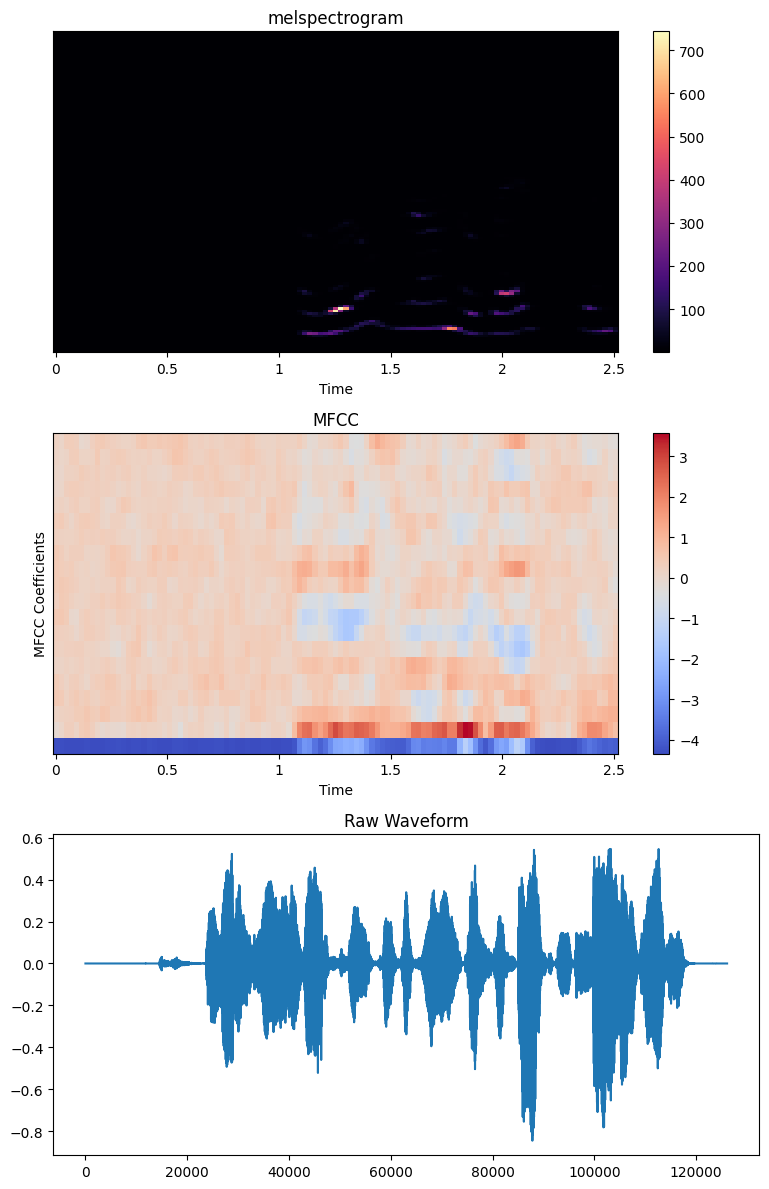

In [66]:
plt.figure(figsize=(15, 12))

# Raw waveform
plt.subplot(3, 2, 5)
plt.plot(y_features)
plt.title('Raw Waveform')

# melspectrogram
plt.subplot(3, 2, 1)
librosa.display.specshow(mel_features, x_axis='time')
plt.colorbar()
plt.title('melspectrogram')

# MFCC
plt.subplot(3, 2, 3)
librosa.display.specshow(mfcc_features, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.ylabel('MFCC Coefficients')

plt.tight_layout()
plt.show()

### Hybrid representation

In [67]:
hybrid_representation_features = np.concatenate((mel_features, mfcc_features), axis=0)
hybrid_representation_features.shape

(148, 109)

In [68]:
test_features = np.expand_dims(hybrid_representation_features, axis=-1)
test_features.shape

(148, 109, 1)

### Train the model

In [69]:
denoised_audio_for_features = dae_f.predict(np.expand_dims(test_features, axis=0))

1/1 [==============================] - 0s 499ms/step


In [70]:
denoised_audio_for_features.shape

(1, 148, 109, 1)

In [71]:
denoised_audio_for_features = np.squeeze(denoised_audio_for_features, axis=0)  # Remove the first dimension
denoised_audio_for_features = np.squeeze(denoised_audio_for_features, axis=-1)  # Remove the last dimension
denoised_audio_for_features.shape

(148, 109)

### Revert transformation

In [72]:
def reconstruct_audio(hybrid_representation, sr, hop_length, n_mels):
    # Reshape hybrid representation to match original Mel spectrogram and MFCC shapes
    mel_reconstructed = hybrid_representation[:n_mels, :]
    mfcc_reconstructed = hybrid_representation[n_mels:, :]

    # Invert MFCC to obtain MFCC features
    mfcc_reconstructed = scal.inverse_transform(mfcc_reconstructed)

    # Invert Mel spectrogram to magnitude spectrogram
    mel_spectrogram_reconstructed = librosa.feature.inverse.mfcc_to_mel(mfcc_reconstructed, n_mels=n_mels)

    # Invert magnitude spectrogram to audio signal
    y_reconstructed_from_mfcc = librosa.feature.inverse.mel_to_audio(mel_spectrogram_reconstructed, sr=sr, hop_length=hop_length)
    
    y_reconstructed_from_mel = librosa.feature.inverse.mel_to_audio(mel_reconstructed, sr=sr, hop_length=hop_length)

    return y_reconstructed_from_mfcc, y_reconstructed_from_mel

In [73]:
y_reconstructed_from_mfcc_feat, y_reconstructed_from_mel_feat = reconstruct_audio(denoised_audio_for_features, sr, hop_length, n_mels)

In [74]:
ipd.Audio(y_reconstructed_from_mfcc_feat, rate=sr)

In [75]:
ipd.Audio(y_reconstructed_from_mel_feat, rate=sr)

In [76]:
## clean audio
ipd.Audio(y_features_noisy, rate=sr)

## Demonstration

In [77]:
ipd.Audio(y_reconstructed_from_mel_feat, rate=sr)

In [78]:
ipd.Audio(y_features_noisy, rate=sr)

In [79]:
ipd.Audio(y_features, rate=sr)

# Noise Audio 

In [80]:
dae_a = load_model('data/noise_on_audio/processed_data/autoencoder_model_audio.keras')

In [81]:
dae_a.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 148, 109, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 109, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 55, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 55, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 28, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 66304)             0     

## Load a test audio file

In [82]:
file_path = "/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/new_metodo/test/10815824_2997e03d76_1.wav"

In [83]:
y_audio, sr = librosa.load(file_path)

In [84]:
sr, y_audio[0].shape

(22050, ())

In [85]:
ipd.Audio(y_audio, rate=sr)

## Preprocess the audio file

In [86]:
y_audio_noisy = add_noise(y_audio)
ipd.Audio(y_audio_noisy, rate=sr)

#### Extract mfcc and melspectrogram

In [87]:
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/new_metodo/weights/scaler.save')

In [88]:
mel_audio, mfcc_audio = compute_mel_mfcc(y_audio_noisy, sr, n_fft, hop_length, n_mels, n_mfcc, fixed_length, scal)

### Hybrid representation

In [89]:
hybrid_representation_audio = np.concatenate((mel_audio, mfcc_audio), axis=0)
hybrid_representation_audio.shape

(148, 109)

In [90]:
test_audio = np.expand_dims(hybrid_representation_audio, axis=-1)
test_audio.shape

(148, 109, 1)

### Train the model

In [91]:
denoised_audio_for_audio = dae_a.predict(np.expand_dims(test_audio, axis=0))

1/1 [==============================] - 0s 111ms/step


In [92]:
denoised_audio_for_audio.shape

(1, 148, 109, 1)

In [93]:
denoised_audio_for_audio = np.squeeze(denoised_audio_for_audio, axis=0)  # Remove the first dimension
denoised_audio_for_audio = np.squeeze(denoised_audio_for_audio, axis=-1)  # Remove the last dimension
denoised_audio_for_audio.shape

(148, 109)

### Revert transformation

In [94]:
y_reconstructed_from_mfcc_audio, y_reconstructed_from_mel_audio = reconstruct_audio(denoised_audio_for_audio, sr, hop_length, n_mels)

In [95]:
ipd.Audio(y_reconstructed_from_mfcc_audio, rate=sr)

In [96]:
ipd.Audio(y_reconstructed_from_mel_audio, rate=sr)

In [97]:
ipd.Audio(y_audio, rate=sr)

## Demonstration

In [98]:
ipd.Audio(y_reconstructed_from_mel_audio, rate=sr)

In [99]:
ipd.Audio(y_audio_noisy, rate=sr)

In [100]:
ipd.Audio(y_audio, rate=sr)

# Comparison

In [101]:
ipd.Audio(y_reconstructed_from_mel_audio, rate=sr)

In [102]:
ipd.Audio(y_reconstructed_from_mel_feat, rate=sr)

In [103]:
ipd.Audio(y_reconstructed_from_mfcc_audio, rate=sr)

In [104]:
ipd.Audio(y_reconstructed_from_mfcc_feat, rate=sr)

-----

In [105]:
ipd.Audio(y_audio_noisy, rate=sr)

In [106]:
ipd.Audio(y_features_noisy, rate=sr)

----

In [107]:
ipd.Audio(y_audio, rate=sr)

In [108]:
ipd.Audio(y_features, rate=sr)

----